In [1]:
import os

import math
import time
import random
from contextlib import contextmanager

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm

import cv2

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, 
    ShiftScaleRotate, Transpose
    )
from albumentations.pytorch import ToTensorV2

import timm

import warnings 
warnings.filterwarnings('ignore')

#from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device={device}")

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


device=cuda


In [2]:
CFG = {}

CFG["debug"]=False

#meta
CFG["project_name"]="NEW PROJECT42"
CFG["train"]=True
CFG["inference"]=False

#data
CFG["train_images"] = 'data/cassava-leaf-disease/train.csv'
CFG["test_images"] = 'data/cassava-leaf-disease/sample_submission.csv'
CFG["train_images_folder"] = 'data/cassava-leaf-disease/train_images'
CFG["test_images_folder"] = 'data/cassava-leaf-disease/test_images'
CFG["target_size"]=5
CFG["target_col"]='label'
CFG["output_folder"] = './output/'

#model
CFG["vision_lib"] = "timm" # {"timm","torchvision"}
CFG["model_name"]='resnext50_32x4d'
CFG["size"]=256
#CFG["model_name"]='vit_base_patch16_224'
#CFG["size"]=224

#system
CFG["num_workers"]=4
CFG["print_freq"]=100
CFG["seed"]=42

#evalution
CFG["n_fold"]=1 #1 for train-val split
CFG["train_val_split"] = 0.1 #ignored if n_fold > 1
CFG["trn_fold"]=[0, 1, 2, 3, 4] #ignored if n_fold == 1

#hyperparameters
CFG["apex"]=False
CFG["scheduler"]='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
CFG["epochs"]=3
#CFG["factor"]=0.2 # ReduceLROnPlateau
#CFG["patience"]=4 # ReduceLROnPlateau
#CFG["eps"]=1e-6 # ReduceLROnPlateau
#CFG["T_max"]=10 # CosineAnnealingLR
CFG["T_0"]=10 # CosineAnnealingWarmRestarts
CFG["lr"]=1e-4
CFG["min_lr"]=1e-6
CFG["batch_size"]=32
CFG["weight_decay"]=1e-6
CFG["gradient_accumulation_steps"]=1
CFG["max_grad_norm"]=1000


In [3]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'lr': {
        'values': [0.01, 0.001, 0.0001, 0.00001]
        },
    }

sweep_config["parameters"] = parameters_dict

In [4]:
# Log in to your W&B account
import wandb

# Use wandb-core
wandb.require("core")

wandb.login()

os.environ["PROJECT_NAME"] = CFG["project_name"]

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sdegroeve. Use `wandb login --relogin` to force relogin


In [5]:
sweep_id = wandb.sweep(sweep_config, project=CFG["project_name"])

Create sweep with ID: hp8cdvev
Sweep URL: https://wandb.ai/sdegroeve/NEW%20PROJECT42/sweeps/hp8cdvev


In [6]:
if CFG["debug"]:
    CFG["epochs"] = 1
    train = train.sample(n=1000, random_state=CFG["seed"]).reset_index(drop=True)
    
if not os.path.exists(CFG["output_folder"]):
    os.makedirs(CFG["output_folder"])

# UTILS

In [7]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=CFG["output_folder"]+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG["seed"])

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

# DATA

In [8]:
train = pd.read_csv(CFG["train_images"])
test = pd.read_csv(CFG["test_images"])
display(train.head())
display(test.head())

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


In [9]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{CFG["train_images_folder"] }/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{CFG["test_images_folder"] }/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

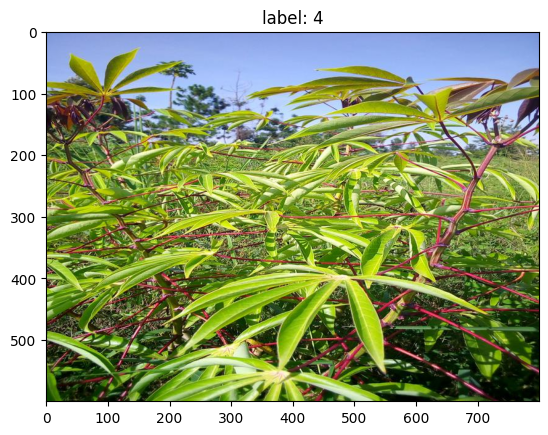

In [10]:
import matplotlib.pyplot as plt

train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[random.randint(0,len(train_dataset)-1)]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [11]:
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG["size"], CFG["size"]),
            RandomResizedCrop(CFG["size"], CFG["size"]),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG["size"], CFG["size"]),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

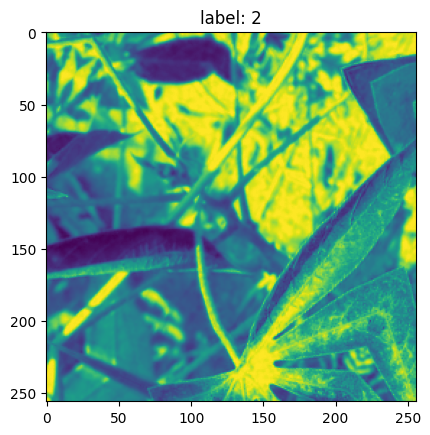

In [12]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[random.randint(0,len(train_dataset)-1)]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# VALIDATION SPLIT

In [13]:
folds = train.copy()

if CFG["n_fold"] == 1:
    tmp = CFG["train_val_split"]*100
    folds['fold'] = [1 if random.randint(0,tmp) < tmp else 0 for x in range(len(folds))]
    print(folds.groupby(['fold', CFG["target_col"]]).size())
else:
    Fold = StratifiedKFold(n_splits=CFG["n_fold"], shuffle=True, random_state=CFG["seed"])
    for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG["target_col"]])):
        folds.loc[val_index, 'fold'] = int(n)
    folds['fold'] = folds['fold'].astype(int)
    print(folds.groupby(['fold', CFG["target_col"]]).size())

fold  label
0     0          100
      1          213
      2          214
      3         1250
      4          240
1     0          987
      1         1976
      2         2172
      3        11908
      4         2337
dtype: int64


# MODEL

In [14]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', model_weights=None, pretrained=False):
        super().__init__()
        if CFG["vision_lib"] == "timm":
            self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=CFG["target_size"])
        if CFG["vision_lib"] == "torchvision":
            self.model = torch.hub.load("pytorch/vision",model_name, weights=model_weights)
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, CFG["target_size"])

    def forward(self, x):
        x = self.model(x)
        return x

In [15]:
model = CustomResNext(model_name=CFG["model_name"], model_weights="IMAGENET1K_V2",pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.5090,  0.1542, -0.1946,  0.0037, -0.1810],
        [ 0.5126,  0.0426, -0.2062, -0.0096, -0.3889],
        [ 0.5456,  0.1681, -0.1946,  0.0261, -0.2445],
        [ 0.2896,  0.0309, -0.2447,  0.0027, -0.3470]],
       grad_fn=<AddmmBackward0>)


In [16]:
print(dir(model))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save

# EPOCH

In [17]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG["gradient_accumulation_steps"] > 1:
            loss = loss / CFG["gradient_accumulation_steps"]
        if CFG["apex"]:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG["max_grad_norm"])
        if (step + 1) % CFG["gradient_accumulation_steps"] == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG["print_freq"] == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG["gradient_accumulation_steps"] > 1:
            loss = loss / CFG["gradient_accumulation_steps"]
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG["print_freq"] == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# TRAIN LOOP

In [18]:
%%wandb

def train_loop(folds, fold):

    config = wandb.config

    LOGGER.info(f"Fold: {fold} training")

    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                            batch_size=CFG["batch_size"], 
                            shuffle=True, 
                            num_workers=CFG["num_workers"], pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                            batch_size=CFG["batch_size"], 
                            shuffle=False, 
                            num_workers=CFG["num_workers"], pin_memory=True, drop_last=False)

    def get_scheduler(optimizer):
        if CFG["scheduler"]=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG["factor"], patience=CFG["patience"], verbose=True, eps=CFG["eps"])
        elif CFG["scheduler"]=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG["T_max"], eta_min=CFG["min_lr"], last_epoch=-1)
        elif CFG["scheduler"]=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG["T_0"], T_mult=1, eta_min=CFG["min_lr"], last_epoch=-1)
        return scheduler


    model = CustomResNext(CFG["model_name"], pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=config["lr"], weight_decay=CFG["weight_decay"], amsgrad=False)
    scheduler = get_scheduler(optimizer)

    if CFG["apex"]:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)


    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG["epochs"]):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG["target_col"]].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        wandb.log({"loss": avg_loss, "epoch": epoch}) 

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        CFG["output_folder"]+f'{CFG["model_name"]}_fold{fold}_best.pth')
    
    check_point = torch.load(CFG["output_folder"]+f'{CFG["model_name"]}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [19]:
def train_sweep(config=None):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG["target_col"]].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    with wandb.init(config=config):
        config=wandb.config
        oof_df = pd.DataFrame()
        for fold in range(CFG["n_fold"]):
            if fold in CFG["trn_fold"]:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"Fold: {fold}")
                get_result(_oof_df)
        get_result(oof_df)

def main():    
    if CFG["train"]:
        # train 
        wandb.agent(sweep_id, train_sweep, count=5)
        # CV result
        # save result
        #oof_df.to_csv(CFG["output_folder"]+'oof_df.csv', index=False)
    
    if CFG["inference"]:
        # inference
        model = CustomResNext(CFG["model_name"], pretrained=False)
        states = [torch.load(CFG["output_folder"]+f'{CFG["model_name"]}_fold{fold}_best.pth') for fold in CFG["trn_fold"]]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG["batch_size"], shuffle=False, 
                                 num_workers=CFG["num_workers"], pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(CFG["output_folder"]+'submission.csv', index=False)

In [20]:
if __name__ == '__main__':
    main()

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=5
wandb: Agent Starting Run: ysmyo53r with config:
wandb: 	lr: 0.0001
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Fold: 0 training
INFO:__main__:Fold: 0 training
Traceback (most recent call last):
  File "/tmp/ipykernel_11866/79488318.py", line 12, in train_sweep
    _oof_df = train_loop(folds, fold)
  File "/tmp/ipykernel_11866/3525964622.py", line 21, in train_loop
    batch_size=config["batch_size"],
  File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
KeyError: 'batch_size'


Run ysmyo53r errored:
Traceback (most recent call last):
  File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_11866/79488318.py", line 12, in train_sweep
    _oof_df = train_loop(folds, fold)
  File "/tmp/ipykernel_11866/3525964622.py", line 21, in train_loop
    batch_size=config["batch_size"],
  File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
KeyError: 'batch_size'

wandb: ERROR Run ysmyo53r errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_11866/79488318.py", line 12, in train_sweep
wandb: ERROR     _oof_df = train_loop(folds, fold)
wandb: ERROR   File "/tmp/ipykernel_11866/3525964

Fold: 0 training
INFO:__main__:Fold: 0 training
Traceback (most recent call last):
  File "/tmp/ipykernel_11866/79488318.py", line 12, in train_sweep
    _oof_df = train_loop(folds, fold)
  File "/tmp/ipykernel_11866/3525964622.py", line 21, in train_loop
    batch_size=config["batch_size"],
  File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
KeyError: 'batch_size'


Run mf67cm7q errored:
Traceback (most recent call last):
  File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_11866/79488318.py", line 12, in train_sweep
    _oof_df = train_loop(folds, fold)
  File "/tmp/ipykernel_11866/3525964622.py", line 21, in train_loop
    batch_size=config["batch_size"],
  File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
KeyError: 'batch_size'

wandb: ERROR Run mf67cm7q errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_11866/79488318.py", line 12, in train_sweep
wandb: ERROR     _oof_df = train_loop(folds, fold)
wandb: ERROR   File "/tmp/ipykernel_11866/3525964

Fold: 0 training
INFO:__main__:Fold: 0 training
Traceback (most recent call last):
  File "/tmp/ipykernel_11866/79488318.py", line 12, in train_sweep
    _oof_df = train_loop(folds, fold)
  File "/tmp/ipykernel_11866/3525964622.py", line 21, in train_loop
    batch_size=config["batch_size"],
  File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
KeyError: 'batch_size'


Run g38cl0xy errored:
Traceback (most recent call last):
  File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_11866/79488318.py", line 12, in train_sweep
    _oof_df = train_loop(folds, fold)
  File "/tmp/ipykernel_11866/3525964622.py", line 21, in train_loop
    batch_size=config["batch_size"],
  File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
KeyError: 'batch_size'

wandb: ERROR Run g38cl0xy errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/svend/deep_learning/env/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_11866/79488318.py", line 12, in train_sweep
wandb: ERROR     _oof_df = train_loop(folds, fold)
wandb: ERROR   File "/tmp/ipykernel_11866/3525964

In [21]:
# inference
model = CustomResNext(CFG["model_name"], pretrained=False)
states = [torch.load(CFG["output_folder"]+f'{CFG["model_name"]}_fold{fold}_best.pth') for fold in CFG["trn_fold"]]
test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=CFG["batch_size"], shuffle=False, 
                            num_workers=CFG["num_workers"], pin_memory=True)
predictions = inference(model, states, test_loader, device)
# submission
test['label'] = predictions.argmax(1)
test[['image_id', 'label']].to_csv(CFG["output_folder"]+'submission.csv', index=False)

  0%|          | 0/1 [00:00<?, ?it/s]